# Plotting Exercises, Part 2

><span style="color: #9370DB">*Bárbara Flores*</span>

## Wealth and Democracy

Let's now pivot from working with example data to real data. Load the World Development Indicator data you worked with over the summer. This is country-level data that includes information on both countries' GDP per capita (a measure of wealth) and the Polity IV scores (a measure of how democratic a country is -- countries with higher scores are liberal democracies, countries with low scores are autocratic.). Use the code below to download the data. 

In [1]:
import pandas as pd
import numpy as np

pd.set_option("mode.copy_on_write", True)

WDI = pd.read_csv(
    "https://raw.githubusercontent.com/nickeubank/"
    "practicaldatascience/master/Example_Data/world-small.csv"
)

Your data should look like this: 

In [2]:
WDI.head()

,country,region,gdppcap08,polityIV
0,Albania,C&E Europe,7715,17.8
1,Algeria,Africa,8033,10.0
2,Angola,Africa,5899,8.0
3,Argentina,S. America,14333,18.0
4,Armenia,C&E Europe,6070,15.0


### Exercise 1

Let's being analyzing this data by estimating a simple linear model ("ordinary least squares") of the relationship between GDP per capita (`gdppcap08`) and democracy scores (`polityIV`). We will do so using the `statsmodel` package, which we'll discuss in detail later is this course. For the momement, just use this code:

```python
import statsmodels.formula.api as smf
results = smf.ols('polityIV ~ gdppcap08',
                   data=wdi).fit()
print(results.summary())
```


In [3]:
import statsmodels.formula.api as smf

results = smf.ols("polityIV ~ gdppcap08", data=WDI).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               polityIV   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     6.981
Date:                Thu, 26 Oct 2023   Prob (F-statistic):            0.00915
Time:                        13:00:12   Log-Likelihood:                -475.14
No. Observations:                 145   AIC:                             954.3
Df Residuals:                     143   BIC:                             960.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.1354      0.721     16.841      0.0

### Exercise 2

Based on the results of this analysis, what would you conclude about about the relationship between `gdppcap08` and `polityIV`? 

(If you aren't familiar with Linear Models and aren't sure how to interprete this, you can also just look at the simple correlation between these two variables using `wdi[['polityIV', 'gdppcap08']].corr()`.)

Write down your conclusions. 

><span style="color: #9370DB">*Based on the results of the previous analysis, a positive correlation between the variables 'gdppcap08' and 'polityIV' is observed. This is reflected in the positive sign of the coefficient (9.602e-05), which has a p-value of 0.009. A p-value of 0.009 is considered low and suggests that the relationship between these two variables is statistically significant, meaning that it is unlikely that this relationship is the result of chance.*</span>
>
><span style="color: #9370DB">*In summary, we can infer that an increase in the value of 'gdppcap08' is generally associated with an increase in 'polityIV'.*</span>



### Exercise 3

Now let's plot the relationship you just estimated statistically. First, use seaborn to create a scatter plot of `polityIV` and `gdppcap08`. Include a title and label your axes (with formatted words, not variable names).

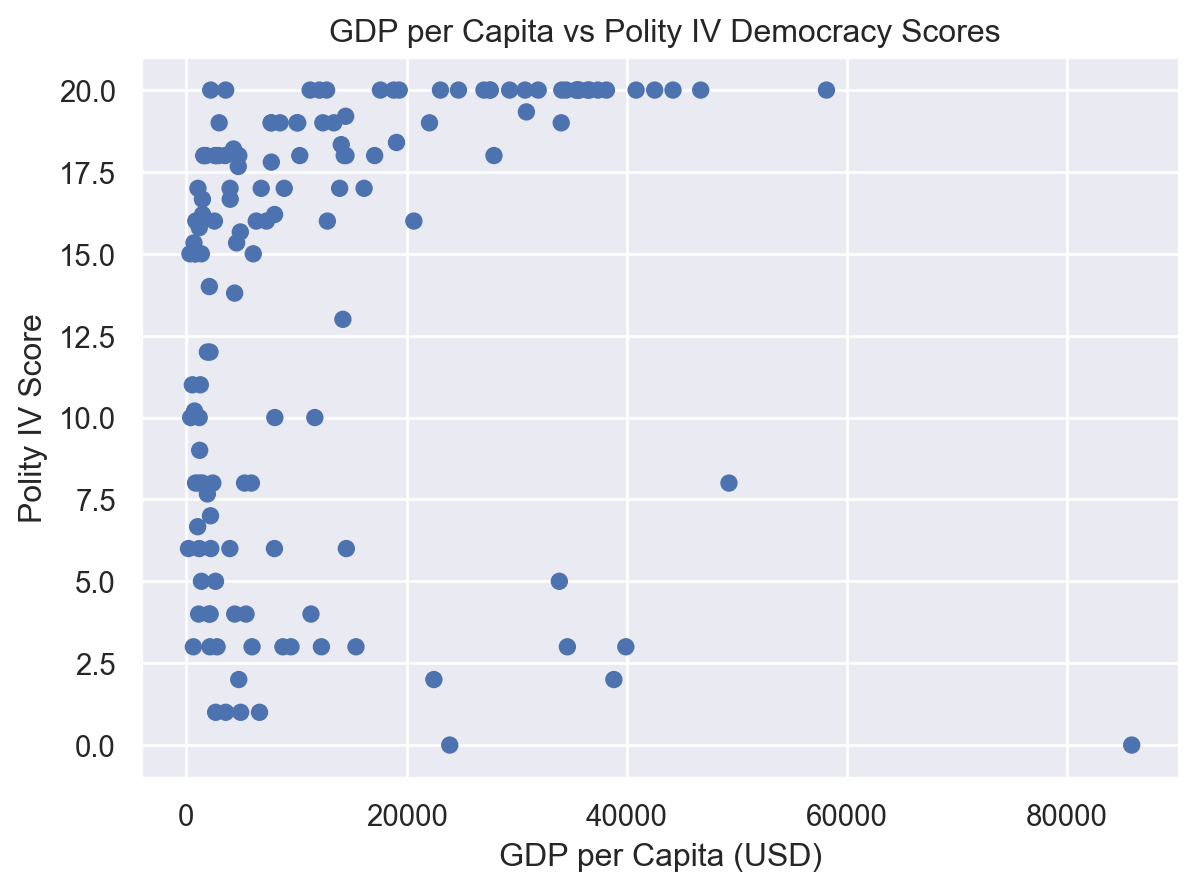

In [4]:
import seaborn.objects as so
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

(
    so.Plot(WDI, x="gdppcap08", y="polityIV")
    .add(so.Dot())
    .label(
        x="GDP per Capita (USD)",
        y="Polity IV Score",
        title=" GDP per Capita vs Polity IV Democracy Scores",
    )
)

### Exercise 4

Now add a linear regression (*not* a higher order polynomial, just linear) fit to the scatter plot.

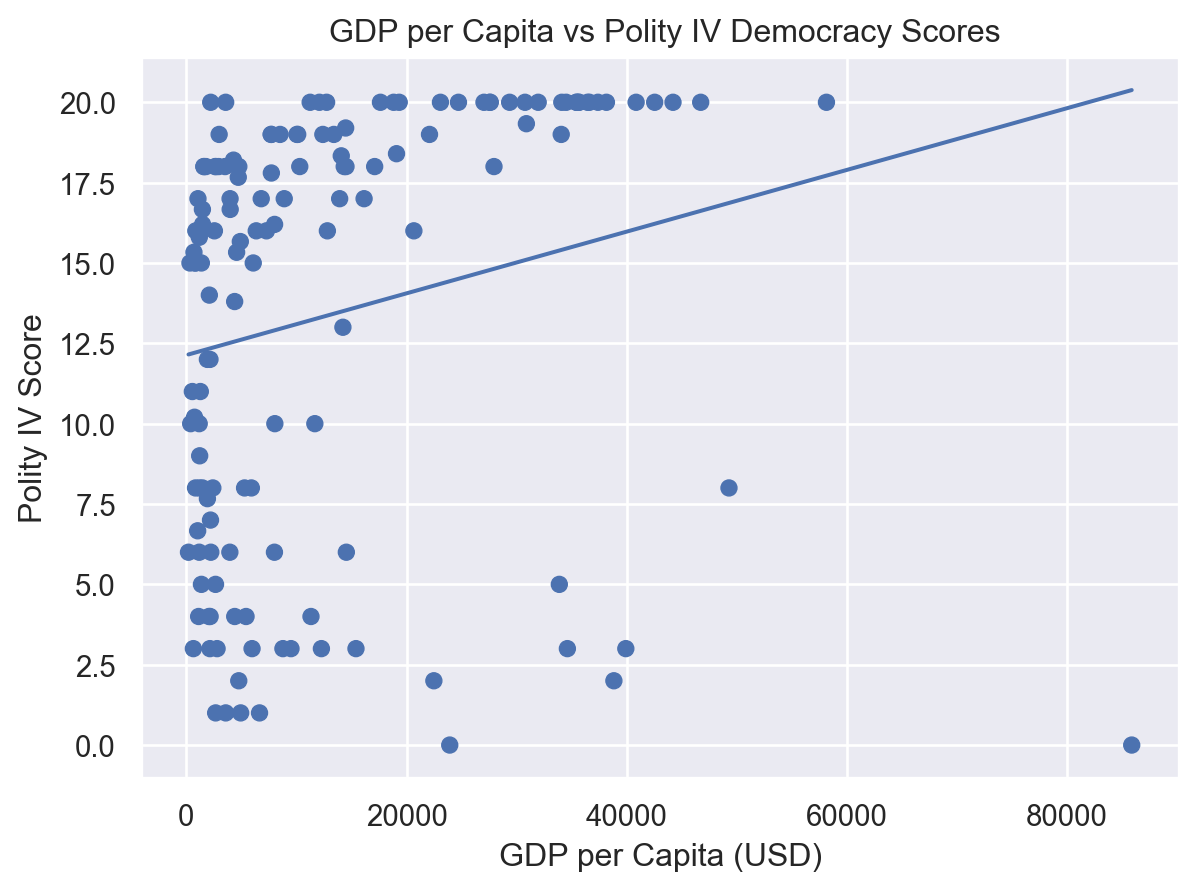

In [5]:
(
    so.Plot(WDI, x="gdppcap08", y="polityIV")
    .add(so.Line(), so.PolyFit(order=1))
    .add(so.Dot())
    .label(
        x="GDP per Capita (USD)",
        y="Polity IV Score",
        title=" GDP per Capita vs Polity IV Democracy Scores",
    )
)

### Exercise 5

Does it seem like the linear model you estimated fits the data well?

><span style="color: #9370DB">*The estimated linear model doesn't fit the data well. It seems that the linear model is not a suitable approximation for representing these data, as it doesn't effectively capture the distribution of points in the graph. The relationship between the variables doesn't appear to be linear, suggesting that another type of model or approach might be more appropriate for describing the underlying relationship in this data.*</span>

### Exercise 6

Linear models impose a very strict functional form on the model they use: they try to draw a straight line through the data, no matter what. 

Can you think of a transform for your data that would make the data a little more sane?

Apply the transformation.

><span style="color: #9370DB">*A logarithmic transformation will be applied to the 'gdppcap08' variable to address its wide range of values. The original 'gdppcap08' data may contain values that vary significantly in magnitude, which could lead to the model being sensitive to outliers and making interpretation challenging. The logarithmic transformation will reduce this variability and ensure that extreme values have a less pronounced impact on the model. This will facilitate the identification of patterns and relationships in the data, allowing for a better interpretation of the relationship between 'gdppcap08' and 'polityIV'*</span>

In [6]:
WDI["log_gdppcap08"] = np.log(WDI["gdppcap08"])

### Exercise 7

Once you've applied that transformation, let's re-fit our model. 

Rather than imposing linearity this time, however, let's fit a model with a flexible functional form. Using the recipe for a [lowess regression you can find here](https://nickeubank.github.io/practicaldatascience_book/notebooks/class_5/week_2/20_plotting_with_seaborn.html#a-little-bonus), see how well a lowess regression fits your updated data. This is a form of local polynomial regression that is designed to be flexible in how it fits the data. 

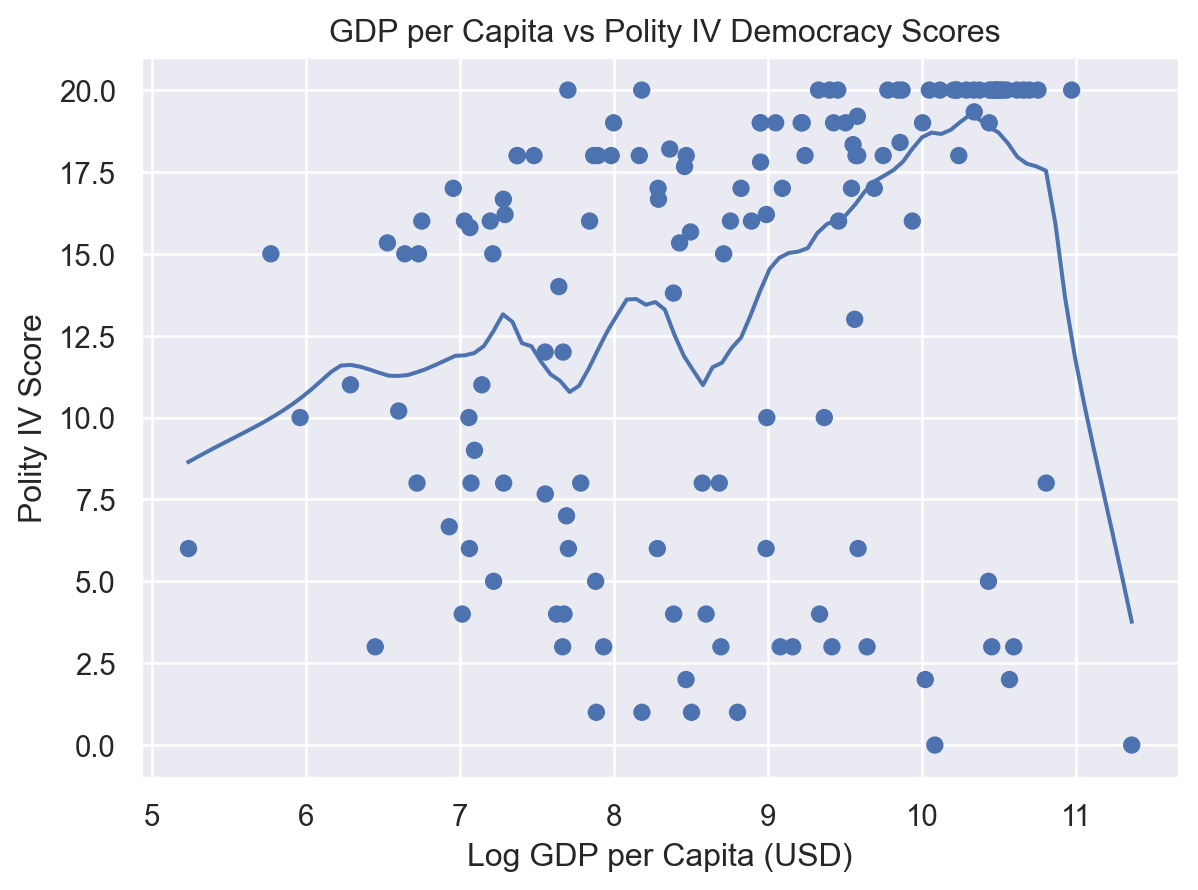

In [7]:
from dataclasses import dataclass
from seaborn._stats.base import Stat
import statsmodels.api as sm


@dataclass
class Lowess(Stat):
    """
    Fit a locally-weighted regression to smooth the data.
    """

    frac: float = 0.2  # Fraction of data to use when estimating each y-value
    gridsize: int = 100  # How fine-grained to plot the curve. Increase if jagged.

    def _fit_predict(self, data):
        x = data["x"]
        xx = np.linspace(x.min(), x.max(), self.gridsize)
        # https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html
        yy = sm.nonparametric.lowess(exog=x, endog=data["y"], xvals=xx, frac=self.frac)
        return pd.DataFrame(dict(x=xx, y=yy))

    def __call__(self, data, groupby, orient, scales):
        return groupby.apply(data.dropna(subset=["x", "y"]), self._fit_predict)


(
    so.Plot(WDI, x="log_gdppcap08", y="polityIV")
    .add(so.Lines(), Lowess())
    .add(so.Dot())
    .label(
        x="Log GDP per Capita (USD)",
        y="Polity IV Score",
        title=" GDP per Capita vs Polity IV Democracy Scores",
    )
)

### Exercise 8

This does seem to fit the data better, but there seem to be quite a few outliers in the bottom right. Who is that? Add text labels to the points on your graph with country names. Make sure the size of your text labels leaves them legible.

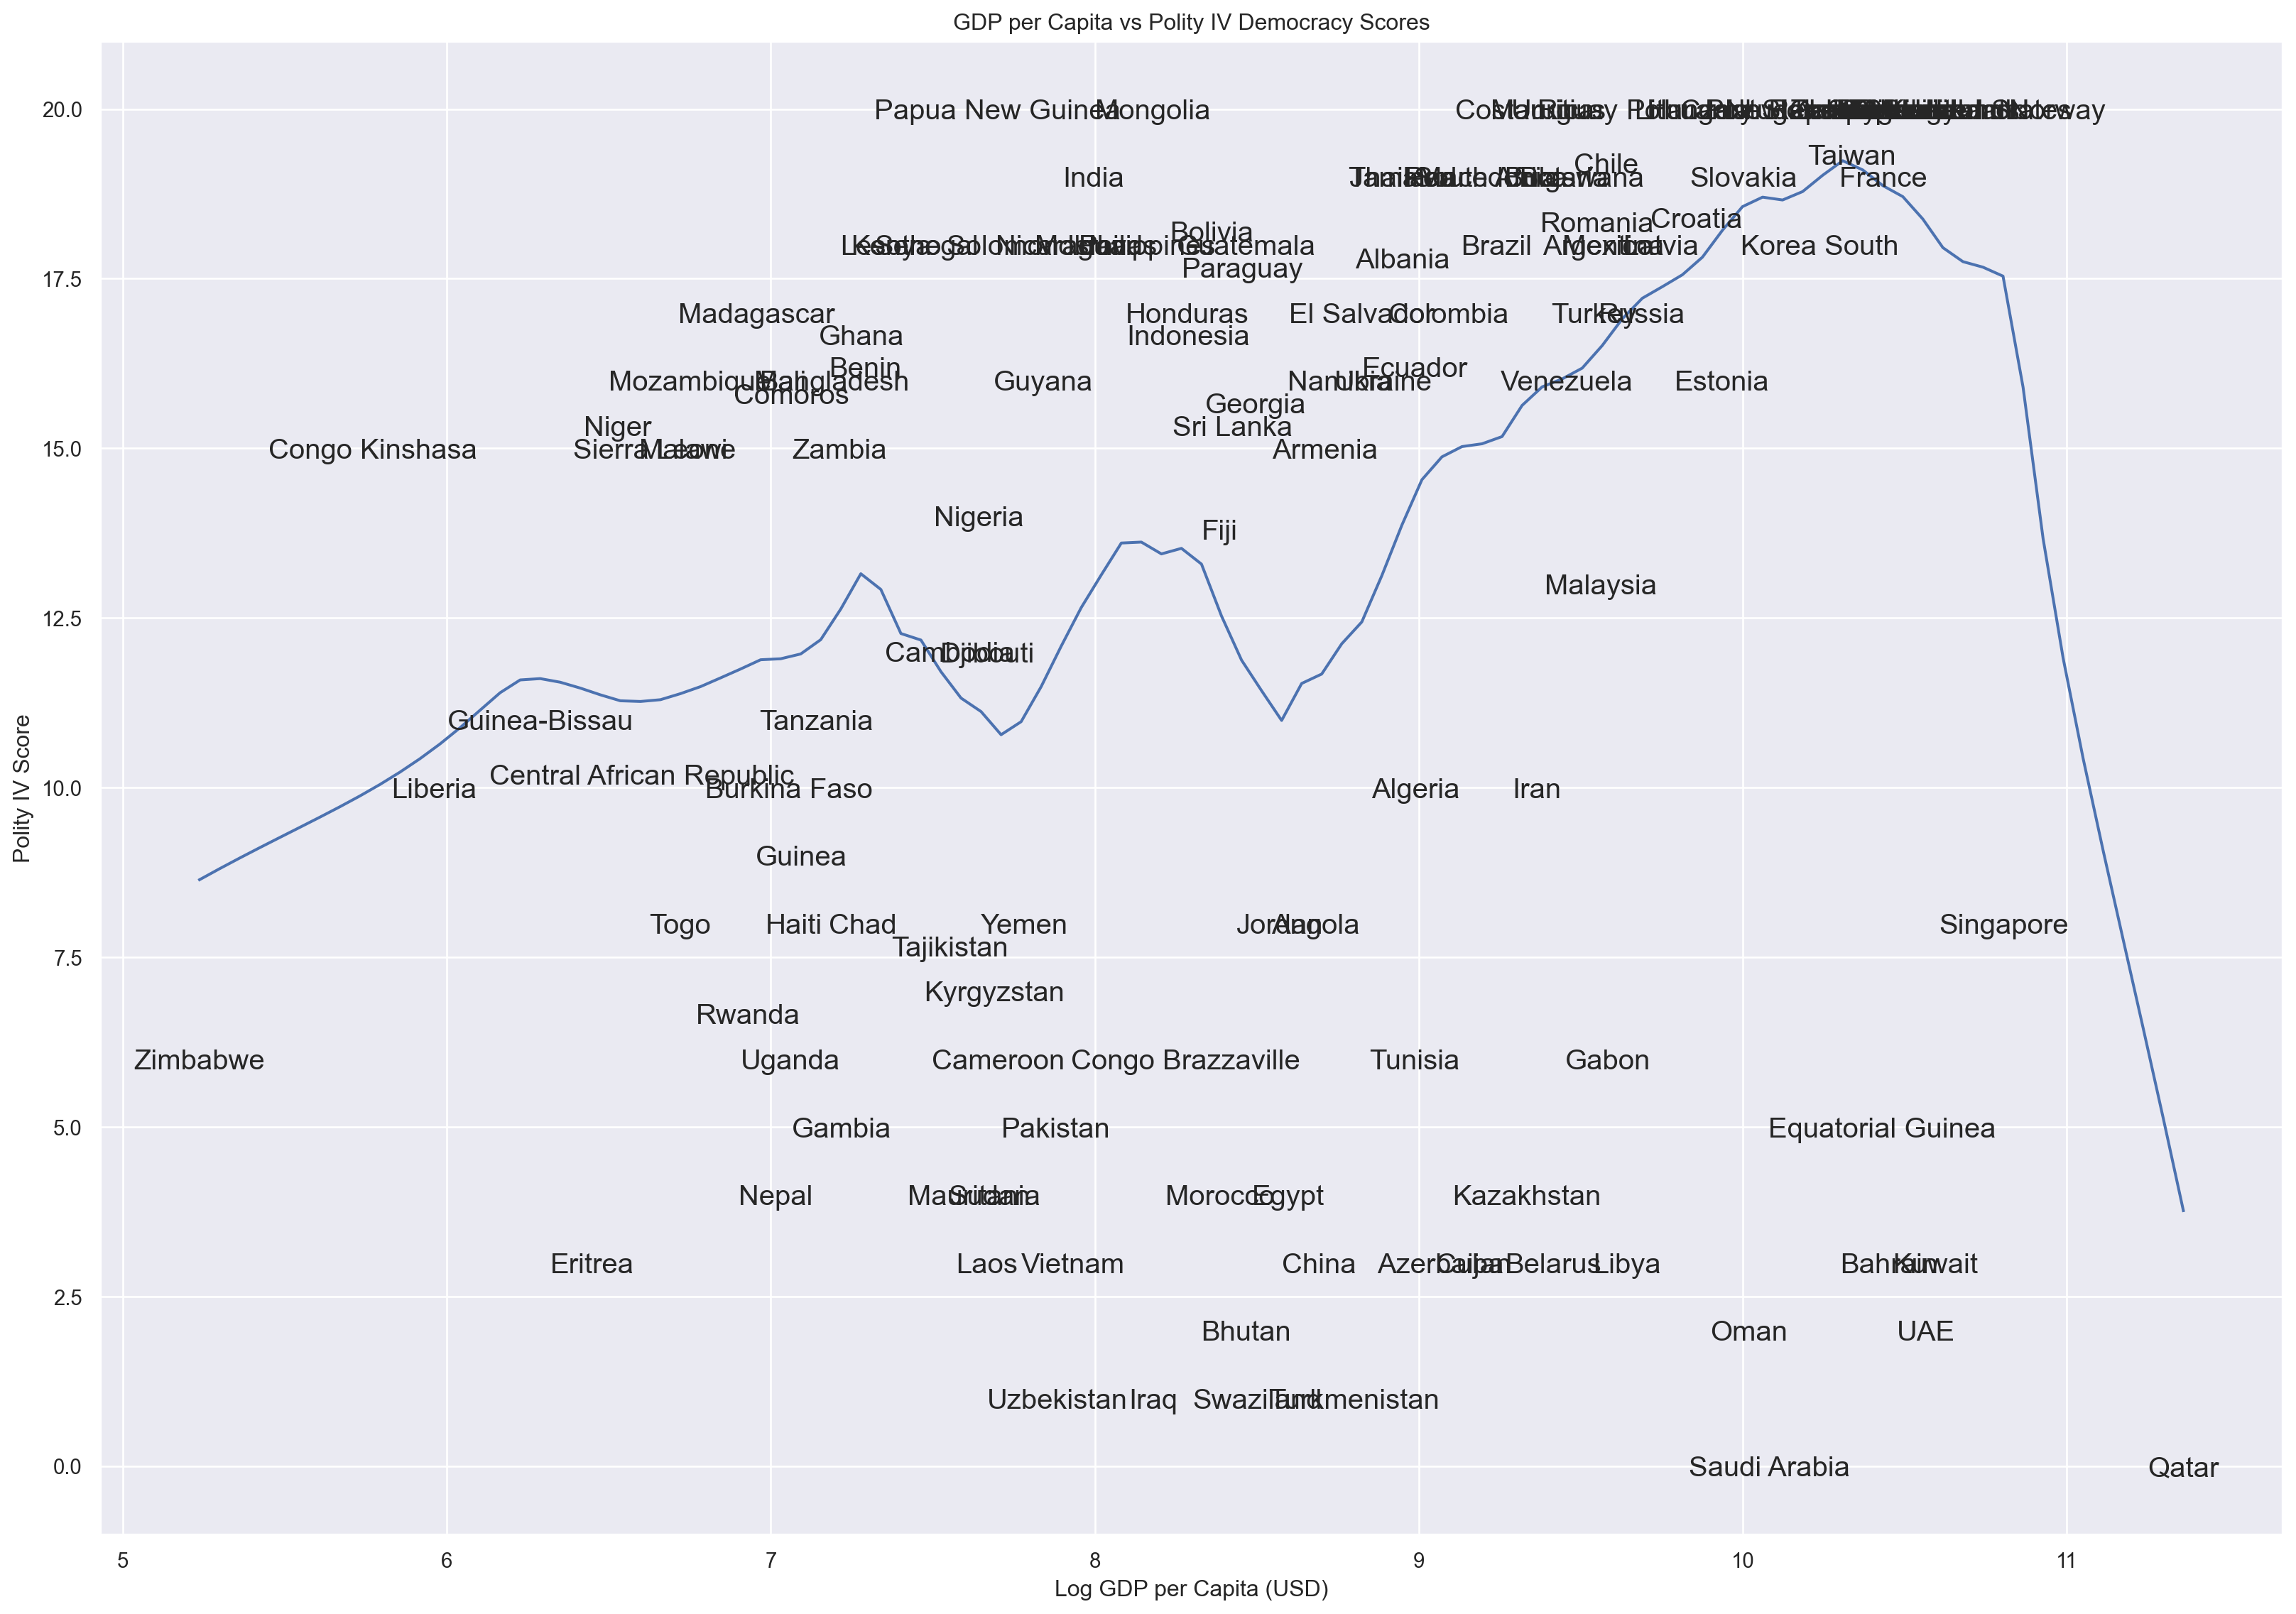

In [8]:
(
    so.Plot(WDI, x="log_gdppcap08", y="polityIV")
    .add(so.Lines(), Lowess())
    # .add(so.Dot())
    .add(so.Text(fontsize=15), text="country")
    .layout(size=(17, 12))
    .label(
        x="Log GDP per Capita (USD)",
        y="Polity IV Score",
        title="GDP per Capita vs Polity IV Democracy Scores",
    )
)

### Exercise 9

Interesting. It seems that there's are a lot of rich, undemocratic countries that all have something in common: they're oil-rich, small, Middle Eastern countries.

Let's see what happens if we exclude the ten countries with the highest per-capita oil production from our data: Qatar, Kuwait, Equatorial Guinea, United Arab Emirates, Norway, Saudi Arabia, Libya, Oman, Gabon, and Angola. (Note this was in 2007, and excludes very small countries!) 

What does the relationship between Polity and GDP per capita look like for non-natural resource producers?

In [9]:
excluded_countries = [
    "Qatar",
    "Kuwait",
    "Equatorial Guinea",
    "United Arab Emirates",
    "Norway",
    "Saudi Arabia",
    "Libya",
    "Oman",
    "Gabon",
    "Angola",
]

# We exclude the ten countries with the highest per-capita oil production.
WDI["Top oil producers"] = WDI["country"].apply(lambda x: x in excluded_countries)
filtered_WDI = WDI[WDI["Top oil producers"] == False]

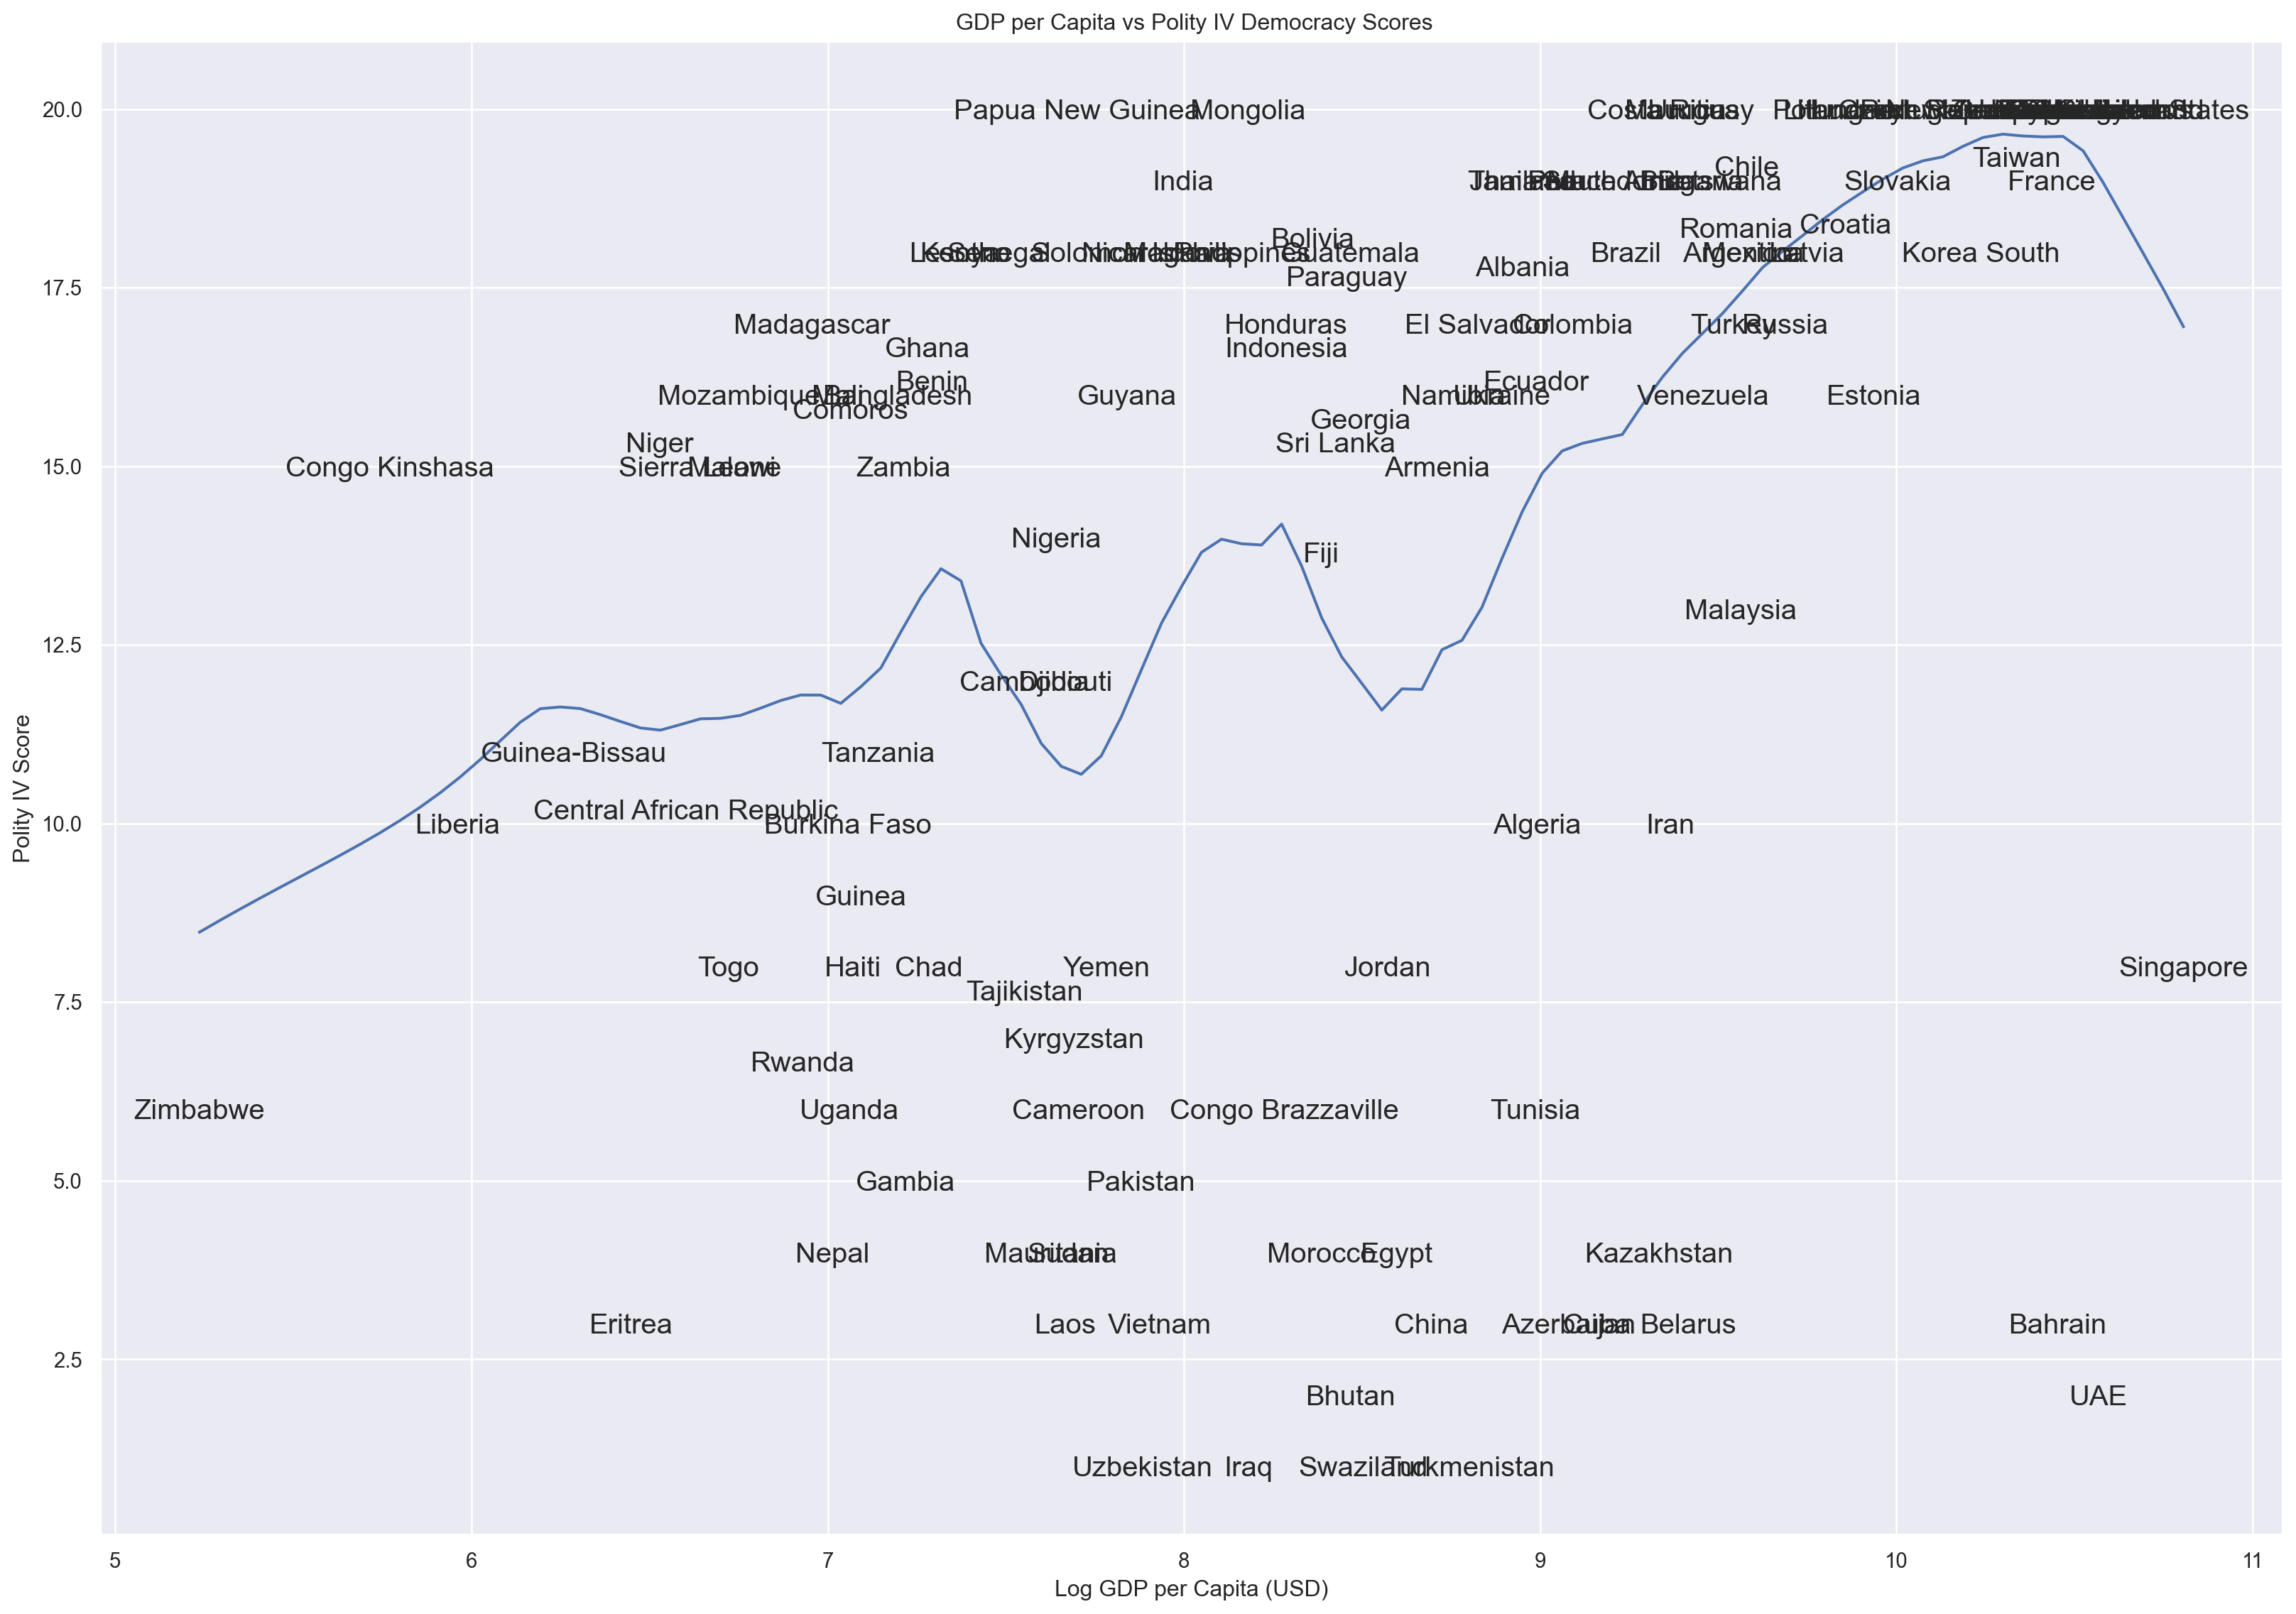

In [10]:
# We plot again
(
    so.Plot(filtered_WDI, x="log_gdppcap08", y="polityIV")
    .add(so.Lines(), Lowess())
    # .add(so.Dot())
    .add(so.Text(fontsize=15), text="country")
    .layout(size=(17, 12))
    .label(
        x="Log GDP per Capita (USD)",
        y="Polity IV Score",
        title=" GDP per Capita vs Polity IV Democracy Scores",
    )
)

><span style="color: #9370DB">*t turns out that when we exclude countries with high per-capita oil production, the relationship between 'Log GDP per Capita (USD)' and 'Polity IV Score' appears to become more linear. This suggests that, in the absence of significant natural resource production, economic and political indicators may have a more predictable relationship, with less influence from factors such as oil wealth. This may indicate the significance of natural resources in a country's economy and politics*</span>

### Exercise 10

Let's make sure that you accurately identified all 10 of the oil producers. Write a line of code to count up how many big producers you have identified. If you do not get 10, can you figure out what you did wrong?

In [11]:
n = len(WDI[WDI["country"].isin(excluded_countries)])
print(f"The number of correctly identified major oil producers is {n}")

The number of correctly identified major oil producers is 9


In [12]:
# "Let's see which countries these are:
WDI[WDI["country"].isin(excluded_countries)]

,country,region,gdppcap08,polityIV,log_gdppcap08,Top oil producers
2,Angola,Africa,5899,8.0,8.682538,True
39,Equatorial Guinea,Africa,33873,5.0,10.430374,True
45,Gabon,Africa,14527,6.0,9.583764,True
71,Kuwait,Middle East,39914,3.0,10.594482,True
77,Libya,Middle East,15402,3.0,9.642253,True
98,Norway,Scandinavia,58138,20.0,10.970575,True
99,Oman,Middle East,22478,2.0,10.020292,True
107,Qatar,Middle East,85868,0.0,11.360567,True
111,Saudi Arabia,Middle East,23920,0.0,10.082470,True


><span style="color: #9370DB">*Upon closer examination of the major oil producer countries that were actually excluded, we realize that we are missing 'United Arab Emirates,' which was not present in our original database.*</span>

### Exercise 11

How does the relationship between GDP per capita and Polity look for the oil producers we dropped above?
(note a Lowess line may not plot if you don't have enough data)

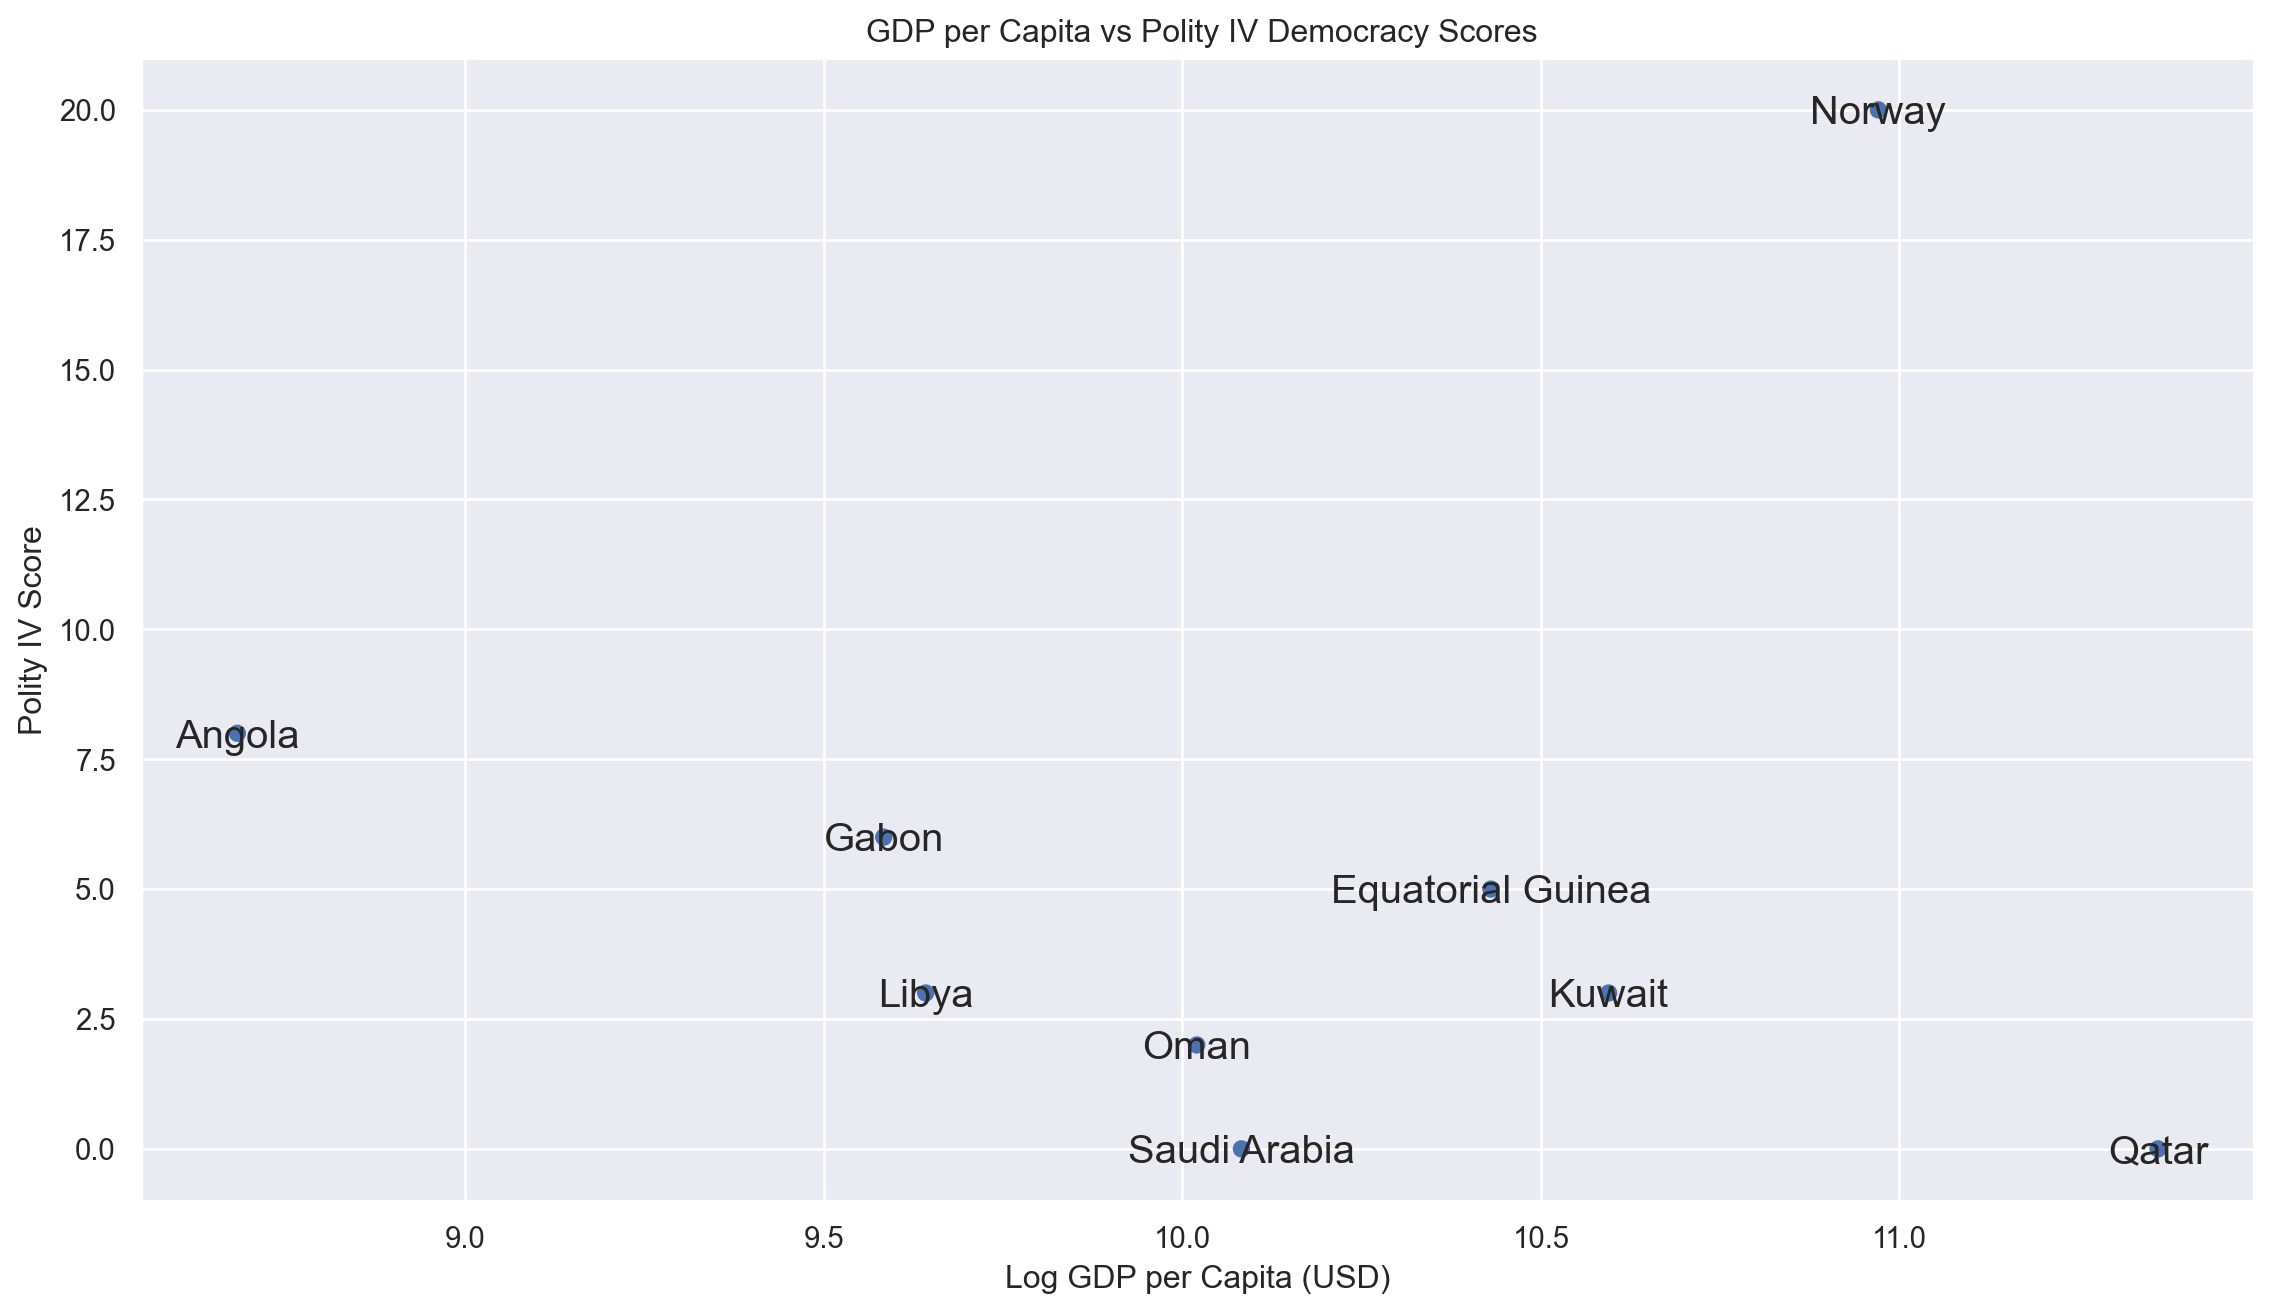

In [18]:
oil_producers_WDI = WDI[WDI["Top oil producers"] == True]

(
    so.Plot(oil_producers_WDI, x="log_gdppcap08", y="polityIV")
    .add(so.Lines(), Lowess())
    .add(so.Dot())
    .add(so.Text(fontsize=15), text="country")
    .layout(size=(12, 7))
    .label(
        x="Log GDP per Capita (USD)",
        y="Polity IV Score",
        title=" GDP per Capita vs Polity IV Democracy Scores",
    )
)

><span style="color: #9370DB">*There doesn't seem to be a clear relationship between the Polity index and GDP per capita for the oil producers we excluded earlier. The absence of an apparent relationship may suggest that in these countries with high oil production, the Polity index doesn't necessarily have a noticeable impact on economic indicators in the same way as in other countries. Other factors, such as the amount or the management of oil resources, may play a significant role.*</span>

### Exercise 12

Look back to your answer for Exercise 2. Do you still believe the result of your linear model? What did you learn from plotting. Write down your answers with your partner. 

><span style="color: #9370DB">*Upon revisiting the response to Question 2, it's important to acknowledge that the initial answer was not entirely accurate. Our initial assessment didn't fully capture the complexity of the 'gdppcap08' and 'polityIV' relationship. We initially missed that a logarithmic model provides a better fit, and the presence of outliers wasn't immediately evident without data visualization.*</span>
>
><span style="color: #9370DB">*Upon closer examination and further analysis, it becomes clear that a positive relationship exists between these variables, with the logarithmic model appearing more suitable.*</span>
>
><span style="color: #9370DB">*This underscores the value of data visualization and exploratory data analysis, enabling us to detect outliers and recognize the appropriateness of a logarithmic model.*</span>

### Exercise 13

Finally, let's make a plot that color codes countries by whether they are big oil producers. Include separate linear regression fits for both groups.

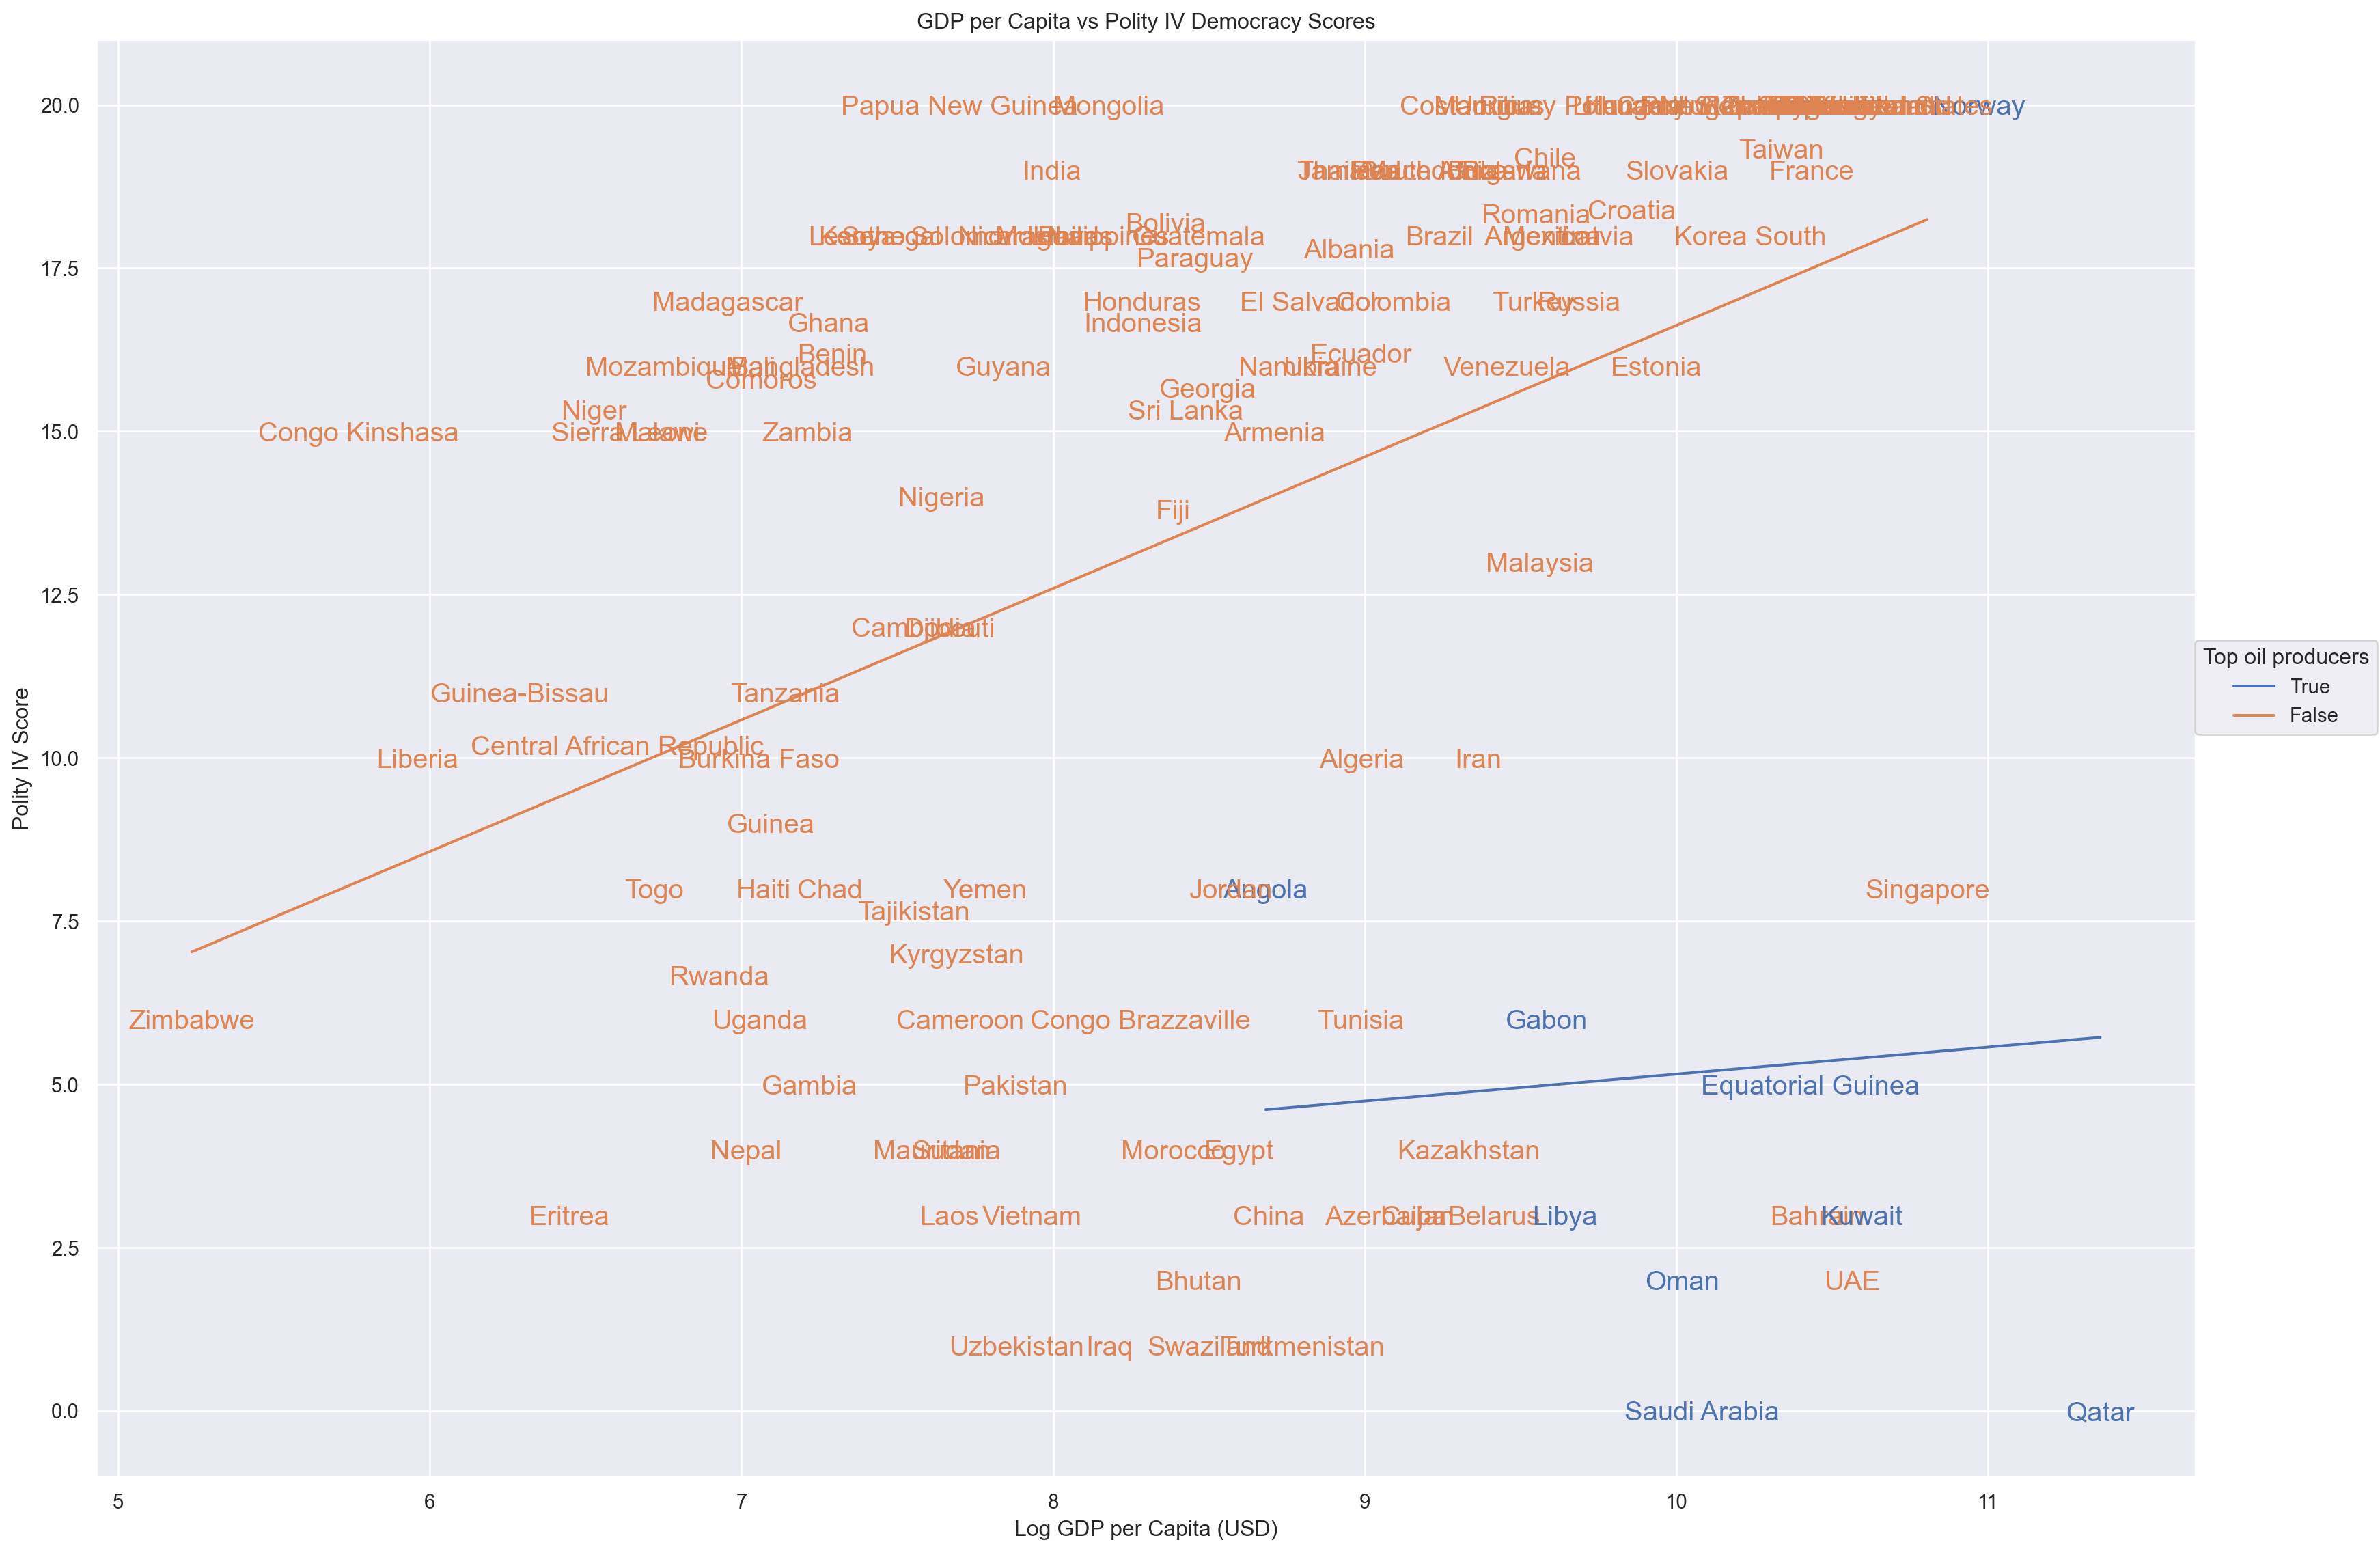

In [14]:
(
    so.Plot(WDI, x="log_gdppcap08", y="polityIV", color="Top oil producers")
    .add(so.Line(), so.PolyFit(order=1))
    # .add(so.Dot())
    .add(so.Text(fontsize=15), text="country")
    .layout(size=(17, 12))
    .label(
        x="Log GDP per Capita (USD)",
        y="Polity IV Score",
        title="GDP per Capita vs Polity IV Democracy Scores",
    )
)

## Take-aways

One of our main jobs as data scientists is to *summarize* data. In fact, its such an obvious part of our jobs we often don't think about it very much. In reality, however, this is one of the most difficult things we do. 

Summarization means taking rich, complex data and trying to tell readers about what is going on in that data using simple statistics. In the process of summarization, therefore, we must necessarily throw away much of the richness of the original data. When done well, this simplification makes data easier to understand, but only if we throw away the *right* data. You can *always* calulate the average value of a variable, or fit a linear model, but whether doing so generates a summary statistic that properly represents the essence of the data being studied depends on the data itself. 

Plotting is one fo the best tools we have as data scientists for evaluating whether we are throwing away the *right* data. As we learned from Part 1 of this exercise, just looking at means and standard deviations can mask tremendous variation. Each of our example datasets looked the same when we examined our summary statistics, but they were all radically different when plotted. 

Similarly, a simple linear model would "tell" us that if GDP per capita increases by \$10,000, we would expect Polity scores to increase by about 1 (i.e. the coefficent on the linear model was 9.602e-05). But when we plot the data, not only can we that the data is definitely *not* linear (and so that slope doesn't really mean anything), but we can also see that oil producing countries seem to defy the overall trend, and so should maybe be studied separately. 

Moreover, we can see that if we just look at oil producers, there is no clear story: some are rich and democratic, while others are rich and autocratic (indeed, [this observation is the foundation of some great research on the political consequences of resource wealth](https://www.jstor.org/stable/41480824)!)

So remember this: tools for summarizing data will always give you an answer, but it's up to you as a data scientist to make sure that the summaries you pass on to other people properly represent the data you're using. And there is perhaps no better way to do this than with plotting!



## Overlaying Data Series with matplotlib

In our last plotting exercises, you were asked to make a paired plot in which different data series were plotted next to one another with a shared x-axis. Presumably that resulted in a figure that looked something like this:

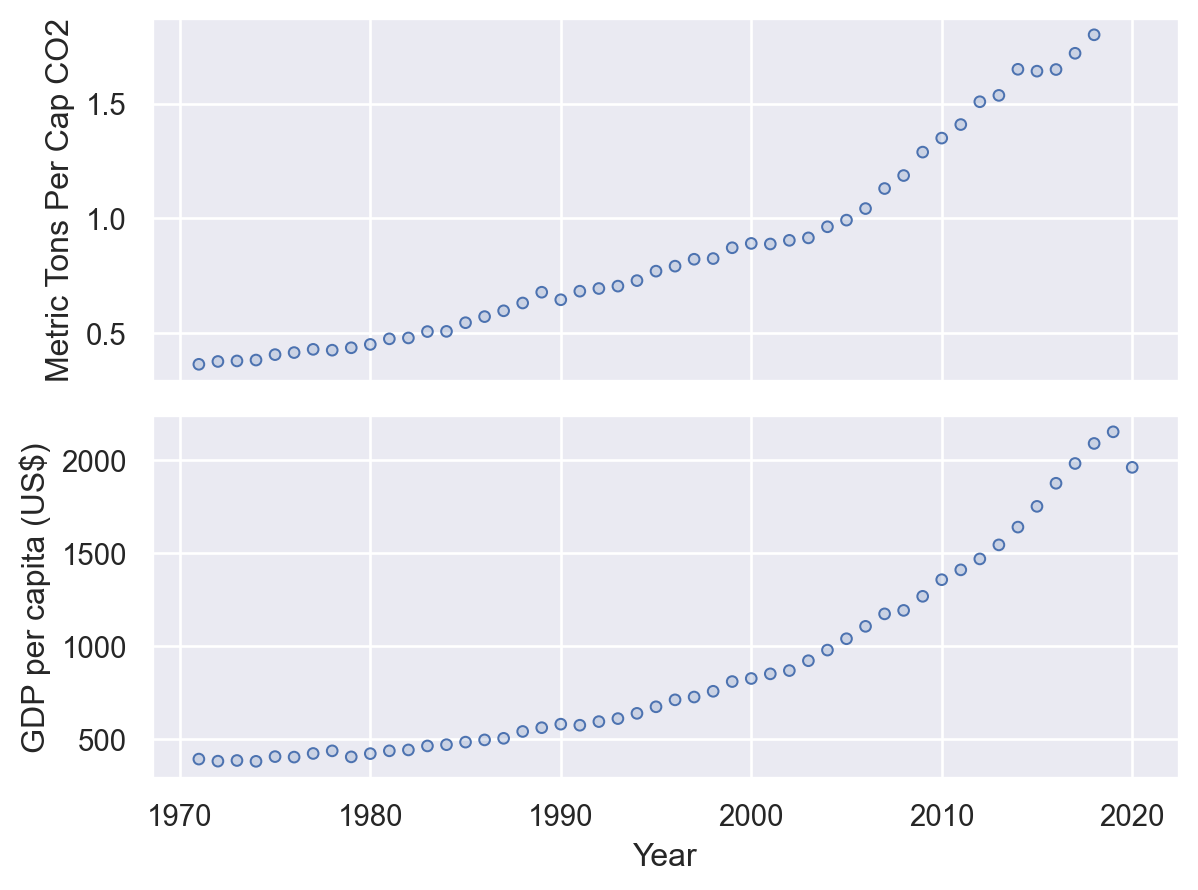

In [15]:
import pandas as pd
import numpy as np

pd.set_option("mode.copy_on_write", True)

import seaborn.objects as so
from matplotlib import style
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

wdi = pd.read_csv(
    "https://raw.githubusercontent.com/nickeubank/"
    "practicaldatascience/master/Example_Data/wdi_plotting.csv"
)

india = wdi[wdi["Country Name"] == "India"]

india = india.rename(
    columns={
        "CO2 emissions (metric tons per capita)": "Metric Tons Per Cap CO2",
        "GDP per capita (constant 2010 US$)": "GDP per capita (US$)",
    }
)
p = (
    so.Plot(
        india,
        x="Year",
    )
    .add(so.Dots())
    .pair(
        y=[
            "Metric Tons Per Cap CO2",
            "GDP per capita (US$)",
        ]
    )
)
p

Often times, however, it's more interesting to directly overlay data series on the same plot to make a figure like this:

![two series sample plot](images/two_series_overlay.png)

So let's do that here!

### Exercise 14

Making this work will require two new tricks: 

- using the `.twinx()` method from matplotlib, and 
- suing the `.on()` method from seaborn.objects.

How? Great question! I'm going to leave it to you to figure that out using the documentation for these methods. But here's a start — you can find the `.on()` [method for seaborn.objects here](https://seaborn.pydata.org/generated/seaborn.objects.Plot.on.html), and the `.twinx()` for matplotlib [method demonstrated here](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html#sphx-glr-gallery-subplots-axes-and-figures-two-scales-py)

Oh, and you may note use these two variables as your two. :) 

Good luck! 

Also, if you want to, feel free to add any extra bells and whistles as part of your exploration (like a legend, or colored y-axis labels).

In [16]:
wdi = pd.read_csv(
    "https://raw.githubusercontent.com/nickeubank/"
    "practicaldatascience/master/Example_Data/wdi_plotting.csv"
)

chile = wdi[wdi["Country Name"] == "chile"]
chile = india.rename(
    columns={
        "Life expectancy at birth, total (years)": "Life expectancy, years (blue)",
        "Population, total": "Population, total (red)",
    }
)

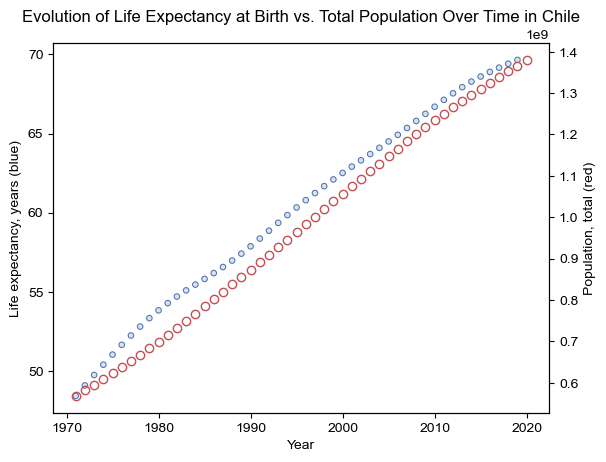

In [17]:
p = so.Plot(chile, "Year", "Life expectancy, years (blue)").add(so.Dots())


f, ax = plt.subplots()

ax2 = ax.twinx()
ax2.title.set_text(
    "Evolution of Life Expectancy at Birth vs. Total Population Over Time in Chile"
)
ax2.plot(
    chile["Year"],
    chile["Population, total (red)"],
    marker="o",
    linestyle="",
    markerfacecolor="none",
    color="r",
)
ax2.set_ylabel("Population, total (red)")


p.on(ax).show()

><span style="color: #9370DB">*In the previous graph, it can be observed that both Life Expectancy at Birth and Population Over Time in Chile have experienced an increase in recent years.*</span>
>
><span style="color: #9370DB">Data visualization is an extremely powerful tool that allows us to gain insights quickly and deliver a wealth of information in a single graph. These charts enable analysts and the general public to understand and analyze trends, patterns, and relationships in data effectively.*</span>